
# ==========================================
# IMPORT LIBRARY & CONNECT DB
# ==========================================


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, silhouette_score 
import warnings
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

print("Library siap")

Library siap



# ==========================================
# BUSINESS UNDERSTANDING
# ==========================================


In [39]:
print("\n[1.1] Determine Business Objectives:")
print("   - Meningkatkan profitabilitas dengan memahami perilaku pelanggan.")
print("   - Mengidentifikasi tren penjualan untuk manajemen stok.")

print("\n[1.2] Assess Situation:")
print("   - Data tersedia dalam format SQL Dump (Star Schema).")
print("   - Tools: Python (Pandas, Scikit-learn).")
print("   - Resources: Data historis transaksi penjualan.")

print("\n[1.3] Determine Data Mining Objectives:")
print("   - Melakukan Customer Segmentation (Clustering).")
print("   - Melakukan Sales Forecasting (Regression).")

print("\n[1.4] Produce Project Plan:")
print("   - Timeline: Load Data -> Clean -> Model -> Evaluate -> Deploy.")
print("   - Success Criteria: Segmentasi yang jelas & Error forecasting rendah.")


[1.1] Determine Business Objectives:
   - Meningkatkan profitabilitas dengan memahami perilaku pelanggan.
   - Mengidentifikasi tren penjualan untuk manajemen stok.

[1.2] Assess Situation:
   - Data tersedia dalam format SQL Dump (Star Schema).
   - Tools: Python (Pandas, Scikit-learn).
   - Resources: Data historis transaksi penjualan.

[1.3] Determine Data Mining Objectives:
   - Melakukan Customer Segmentation (Clustering).
   - Melakukan Sales Forecasting (Regression).

[1.4] Produce Project Plan:
   - Timeline: Load Data -> Clean -> Model -> Evaluate -> Deploy.
   - Success Criteria: Segmentasi yang jelas & Error forecasting rendah.


# ==========================================
#  BLOK 2: DATA UNDERSTANDING
# ==========================================

[2.1] Loading Data from SQL...
   -> Data Loaded Successfully!
   -> fact_sales: 1000 rows
   -> dim_customer: 1000 rows
   -> dim_product: 3 rows
   -> dim_date: 345 rows

[2.2] Exploring Data Structure...
   -> Final Dataset Rows: 1000
   -> Columns: ['sk_date', 'sk_customer', 'sk_product', 'sk_store', 'final_qty', 'final_amount', 'total_orders', 'fact_id', 'Customer ID', 'Age', 'Gender', 'Product Category', 'technical', 'Date', 'Year', 'Month', 'Day', 'Quarter', 'smart_key']

   -> Sample Data:


,sk_date,sk_customer,sk_product,sk_store,final_qty,final_amount,total_orders,fact_id,Customer ID,Age,Gender,Product Category,technical,Date,Year,Month,Day,Quarter,smart_key
0,20230101,180,2,4,3,900,1,761,CUST180,41,Male,Clothing,138,2023-01-01,2023,1,1,1,20230101
1,20230101,522,1,3,3,1500,1,762,CUST522,46,Male,Beauty,138,2023-01-01,2023,1,1,1,20230101
2,20230101,559,2,4,4,1200,1,763,CUST559,40,Female,Clothing,138,2023-01-01,2023,1,1,1,20230101
3,20230102,163,2,4,3,150,1,764,CUST163,64,Female,Clothing,127,2023-01-02,2023,1,2,1,20230102
4,20230102,303,3,1,3,90,1,765,CUST303,19,Male,Electronics,127,2023-01-02,2023,1,2,1,20230102



   -> Data Types:
sk_date                      int64
sk_customer                  int64
sk_product                   int64
sk_store                     int64
final_qty                    int64
final_amount                 int64
total_orders                 int64
fact_id                      int64
Customer ID                 object
Age                          int64
Gender                      object
Product Category            object
technical                    int64
Date                datetime64[ns]
Year                         int64
Month                        int64
Day                          int64
Quarter                      int64
smart_key                    int64
dtype: object

[2.3] Missing Value Analysis...


,Missing Count,Missing %
sk_date,0,0.0
sk_customer,0,0.0
sk_product,0,0.0
sk_store,0,0.0
final_qty,0,0.0
final_amount,0,0.0
total_orders,0,0.0
fact_id,0,0.0
Customer ID,0,0.0
Age,0,0.0


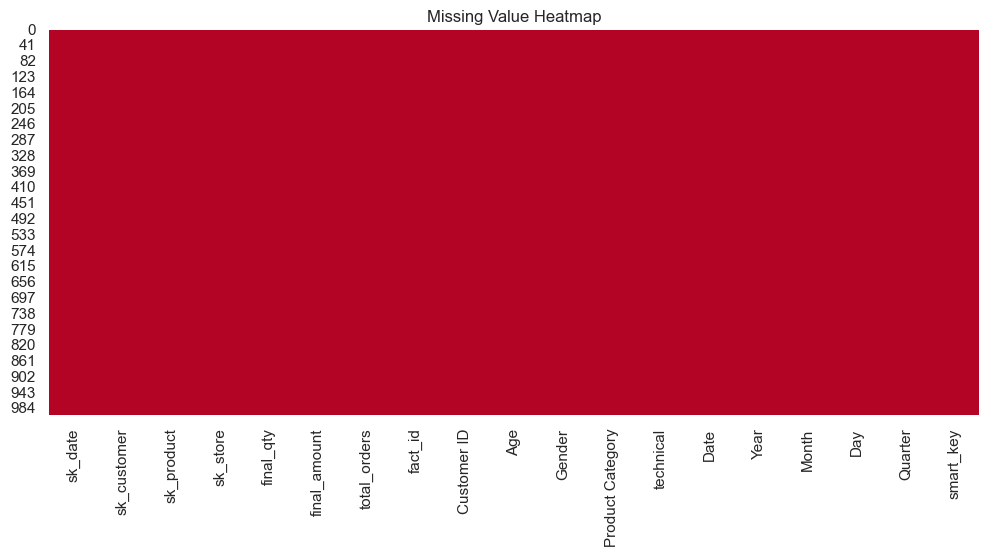

   -> Missing value heatmap ditampilkan.

[2.4] Duplicate Check...
   -> Total Duplicate Rows: 0

[2.5] Referential Integrity Check...
   -> Missing Customer Join: 0 rows
   -> Missing Product Join: 0 rows
   -> Missing Date Join: 0 rows

[2.6] Numeric Distribution...


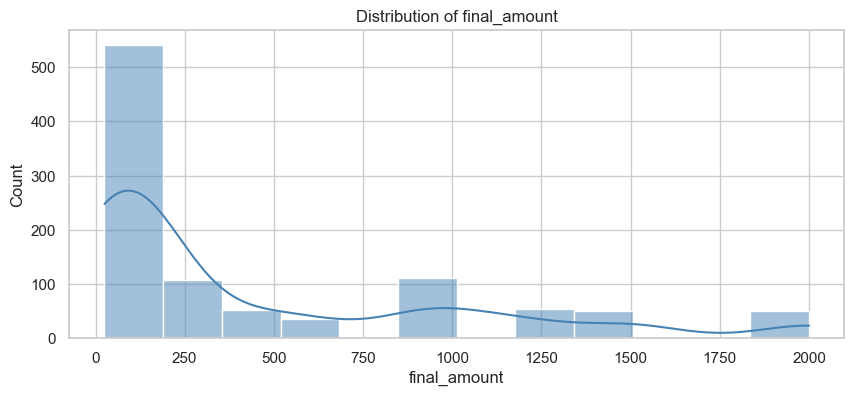

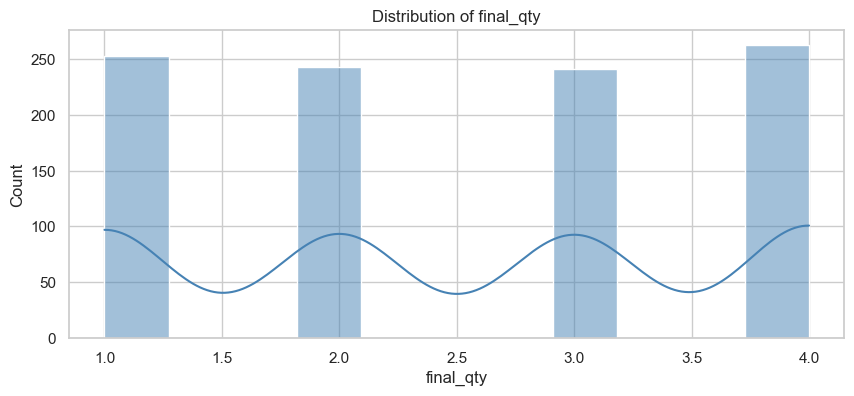

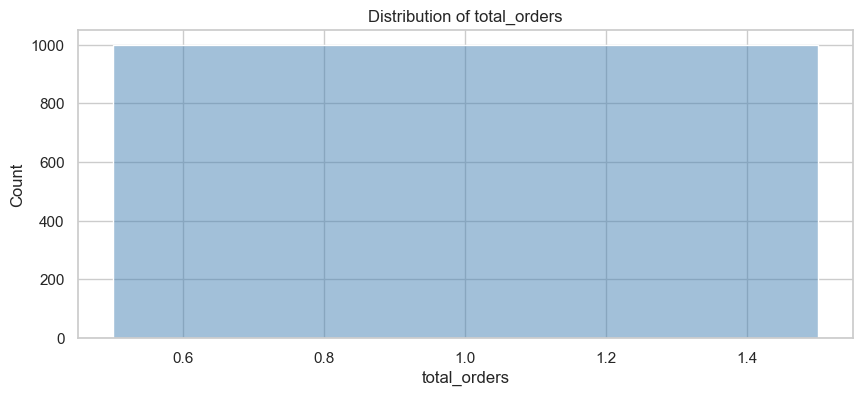

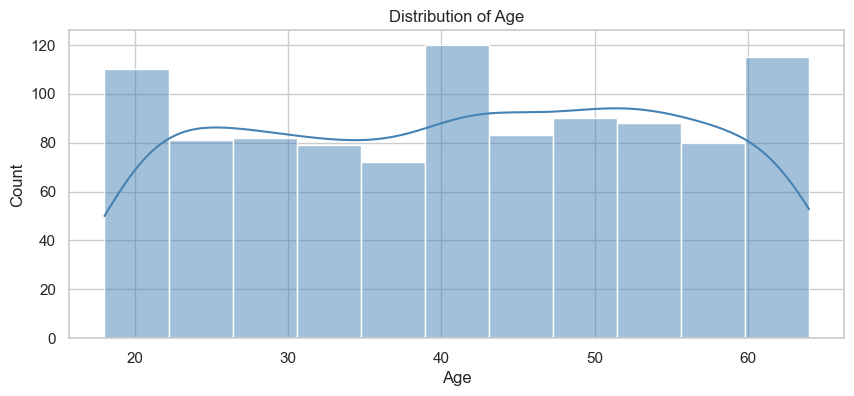

   -> Numeric distributions ditampilkan.

[2.7] Outlier Detection...


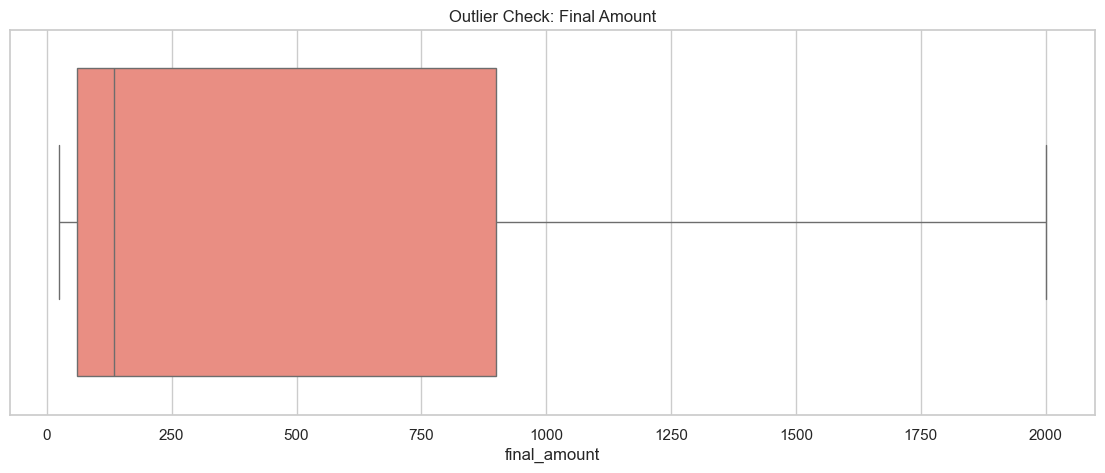

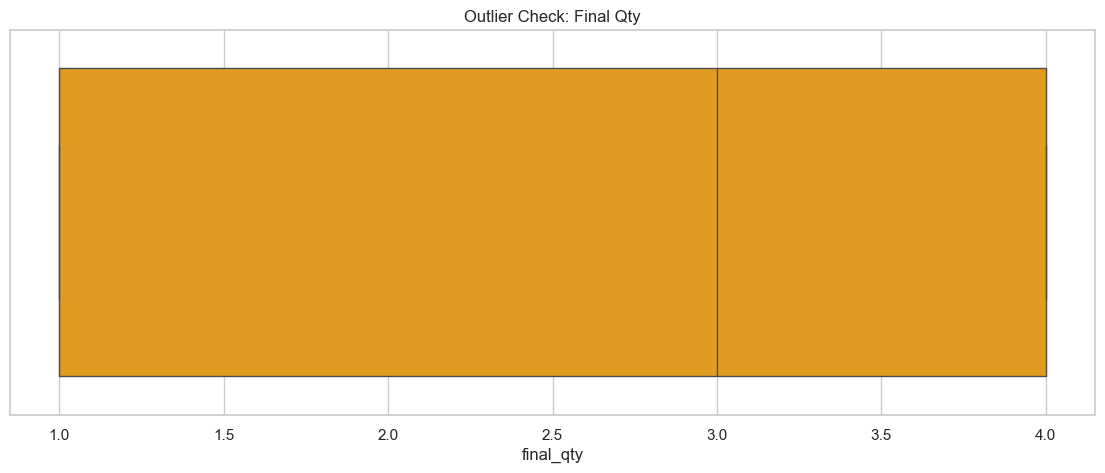

   -> Outlier boxplots ditampilkan.

[2.8] Categorical Distribution...

   -> Value Counts for Gender
Gender
Female    510
Male      490
Name: count, dtype: int64


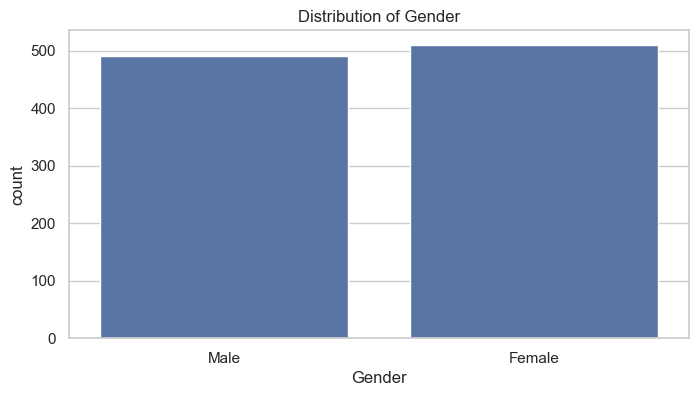


   -> Value Counts for Product Category
Product Category
Clothing       351
Electronics    342
Beauty         307
Name: count, dtype: int64


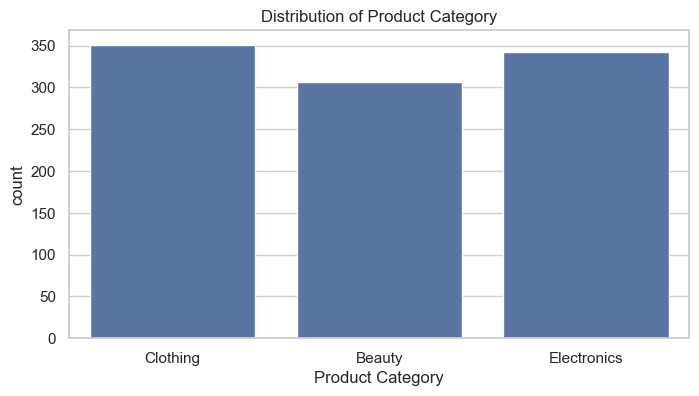


[2.9] Correlation Matrix...


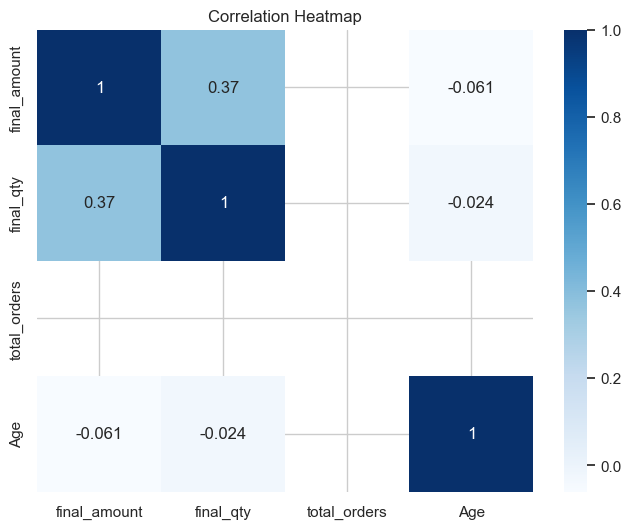


[2.10] Visualizing Anomalies & Distribution (Early Check)...


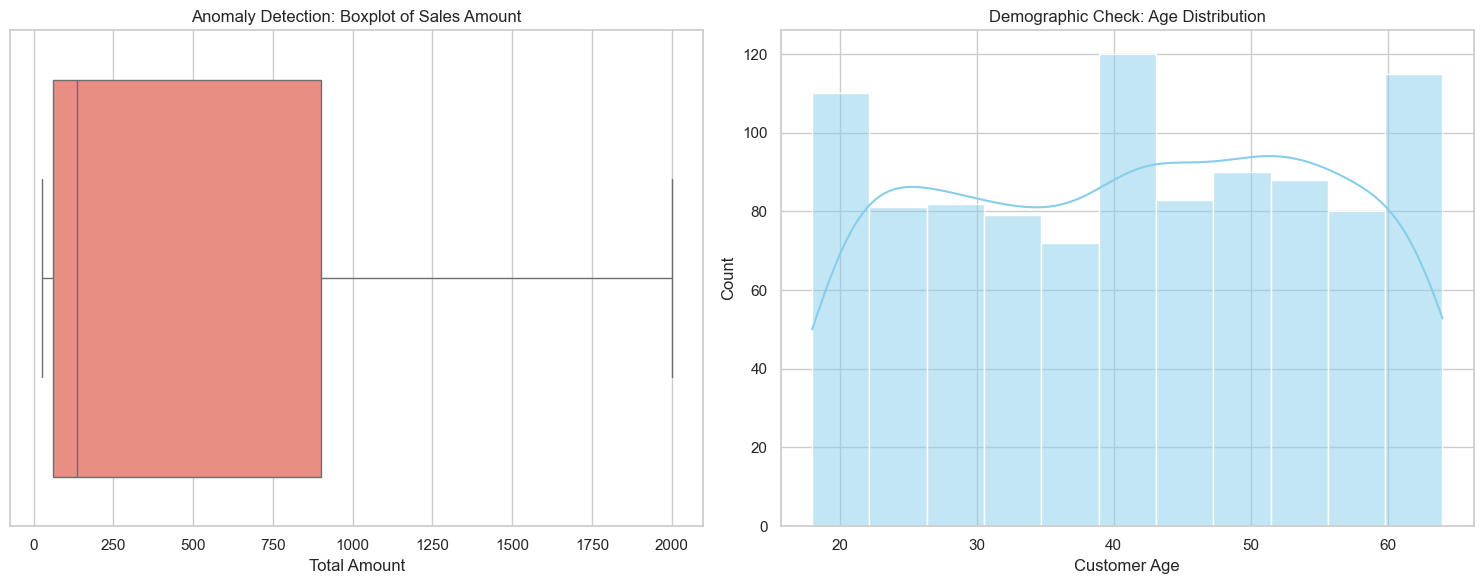

   -> Diagram Anomali (Boxplot) & Distribusi Ditampilkan.


In [40]:

def parse_sql_inserts(file_path, table_name, columns):
    try:
        with open(file_path, 'r', encoding='utf-8') as f: content = f.read()
    except:
        with open(file_path, 'r', encoding='latin-1') as f: content = f.read()
    
    pattern = re.compile(f"INSERT INTO `{table_name}` \((.*?)\) VALUES\s*(.*?;)", re.DOTALL)
    match = pattern.search(content)
    if not match: return pd.DataFrame(columns=columns)
    
    values_str = match.group(2).strip().rstrip(';')
    rows = re.split(r'\),\s*\(', values_str)
    data = []
    for row in rows:
        row = row.lstrip('(').rstrip(')')
        try:
            data.append(eval(f"({row})"))
        except: pass
    return pd.DataFrame(data, columns=columns)

print("[2.1] Loading Data from SQL...")

cols_fact = ['sk_date', 'sk_customer', 'sk_product', 'sk_store', 'final_qty', 'final_amount', 'total_orders', 'fact_id']
cols_cust = ['sk_customer', 'Customer ID', 'Age', 'Gender']
cols_prod = ['sk_product', 'Product Category']
cols_date = ['technical', 'Date', 'Year', 'Month', 'Day', 'Quarter', 'smart_key']

df_fact = parse_sql_inserts('tubes_dwbi.sql', 'fact_sales', cols_fact)
df_cust = parse_sql_inserts('tubes_dwbi.sql', 'dim_customer', cols_cust)
df_prod = parse_sql_inserts('tubes_dwbi.sql', 'dim_product', cols_prod)
df_date = parse_sql_inserts('tubes_dwbi.sql', 'dim_date', cols_date)

print("   -> Data Loaded Successfully!")
print(f"   -> fact_sales: {len(df_fact)} rows")
print(f"   -> dim_customer: {len(df_cust)} rows")
print(f"   -> dim_product: {len(df_prod)} rows")
print(f"   -> dim_date: {len(df_date)} rows")

print("\n[2.2] Exploring Data Structure...")

df = df_fact.merge(df_cust, on='sk_customer', how='left')
df = df.merge(df_prod, on='sk_product', how='left')
df = df.merge(df_date, left_on='sk_date', right_on='smart_key', how='left')

df['Date'] = pd.to_datetime(df['Date'])

print(f"   -> Final Dataset Rows: {len(df)}")
print(f"   -> Columns: {list(df.columns)}")

print("\n   -> Sample Data:")
display(df.head())

print("\n   -> Data Types:")
print(df.dtypes)

print("\n[2.3] Missing Value Analysis...")

missing_counts = df.isna().sum()
missing_percent = (df.isna().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_percent.round(2)
})

display(missing_df)

plt.figure(figsize=(12,5))
sns.heatmap(df.isna(), cbar=False, cmap="coolwarm_r")
plt.title("Missing Value Heatmap")
plt.show()

print("   -> Missing value heatmap ditampilkan.")

print("\n[2.4] Duplicate Check...")

dup_total = df.duplicated().sum()
print(f"   -> Total Duplicate Rows: {dup_total}")

print("\n[2.5] Referential Integrity Check...")

missing_customer = df[df['Customer ID'].isna()]
missing_product  = df[df['Product Category'].isna()]
missing_date     = df[df['Date'].isna()]

print(f"   -> Missing Customer Join: {len(missing_customer)} rows")
print(f"   -> Missing Product Join: {len(missing_product)} rows")
print(f"   -> Missing Date Join: {len(missing_date)} rows")

print("\n[2.6] Numeric Distribution...")

num_cols = ['final_amount', 'final_qty', 'total_orders', 'Age']

for col in num_cols:
    if col in df.columns:
        plt.figure(figsize=(10,4))
        sns.histplot(df[col], kde=True, color='steelblue')
        plt.title(f"Distribution of {col}")
        plt.show()

print("   -> Numeric distributions ditampilkan.")

print("\n[2.7] Outlier Detection...")

plt.figure(figsize=(14,5))
sns.boxplot(x=df['final_amount'], color='salmon')
plt.title('Outlier Check: Final Amount')
plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(x=df['final_qty'], color='orange')
plt.title('Outlier Check: Final Qty')
plt.show()

print("   -> Outlier boxplots ditampilkan.")

print("\n[2.8] Categorical Distribution...")

cat_cols = ['Gender', 'Product Category']
for col in cat_cols:
    if col in df.columns:
        print(f"\n   -> Value Counts for {col}")
        print(df[col].value_counts())

        plt.figure(figsize=(8,4))
        sns.countplot(x=df[col])
        plt.title(f"Distribution of {col}")
        plt.show()

print("\n[2.9] Correlation Matrix...")

corr_cols = ['final_amount', 'final_qty', 'total_orders', 'Age']
corr = df[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()

print("\n[2.10] Visualizing Anomalies & Distribution (Early Check)...")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['final_amount'], color='salmon')
plt.title('Anomaly Detection: Boxplot of Sales Amount')
plt.xlabel('Total Amount')

plt.subplot(1, 2, 2)
sns.histplot(df['Age'], kde=True, color='skyblue')
plt.title('Demographic Check: Age Distribution')
plt.xlabel('Customer Age')

plt.tight_layout()
plt.show()

print("   -> Diagram Anomali (Boxplot) & Distribusi Ditampilkan.")


# ==========================================
# BLOK 3: DATA PREPARATION
# ==========================================

[3.2] Constructing Data (Resampling to Weekly)...
   -> Sorting data berdasarkan kolom Date...
   -> Sample data setelah sorting:


,sk_date,sk_customer,sk_product,sk_store,final_qty,final_amount,total_orders,fact_id,Customer ID,Age,Gender,Product Category,technical,Year,Month,Day,Quarter,smart_key
Date,,,,,,,,,,,,,,,,,,
2023-01-01,20230101,180,2,4,3,900,1,761,CUST180,41,Male,Clothing,138,2023,1,1,1,20230101
2023-01-01,20230101,522,1,3,3,1500,1,762,CUST522,46,Male,Beauty,138,2023,1,1,1,20230101
2023-01-01,20230101,559,2,4,4,1200,1,763,CUST559,40,Female,Clothing,138,2023,1,1,1,20230101
2023-01-02,20230102,163,2,4,3,150,1,764,CUST163,64,Female,Clothing,127,2023,1,2,1,20230102
2023-01-02,20230102,303,3,1,3,90,1,765,CUST303,19,Male,Electronics,127,2023,1,2,1,20230102
2023-01-02,20230102,421,2,4,3,1500,1,766,CUST421,37,Female,Clothing,127,2023,1,2,1,20230102
2023-01-02,20230102,979,1,2,1,25,1,767,CUST979,19,Female,Beauty,127,2023,1,2,1,20230102
2023-01-03,20230103,610,1,3,2,600,1,768,CUST610,26,Female,Beauty,298,2023,1,3,1,20230103
2023-01-04,20230104,32,1,3,3,90,1,769,CUST032,30,Male,Beauty,31,2023,1,4,1,20230104



   -> Melakukan resampling data ke level mingguan (weekly)...
   -> Data dikompres dari 1000 transaksi jadi 54 titik data mingguan
   -> Grafik bakal lebih smooth dan tidak noise

   -> Sample tabel weekly_sales:


,Date,final_amount,Time_Index
0,2023-01-01,3600,0
1,2023-01-08,6100,1
2,2023-01-15,4850,2
3,2023-01-22,8215,3
4,2023-01-29,9845,4
5,2023-02-05,13070,5
6,2023-02-12,8365,6
7,2023-02-19,13815,7
8,2023-02-26,7645,8
9,2023-03-05,7155,9



   -> Statistik ringkas weekly_sales:


,Date,final_amount,Time_Index
count,54,54.000000,54.000000
mean,2023-07-05 12:00:00,8444.444444,26.500000
min,2023-01-01 00:00:00,1530.000000,0.000000
25%,2023-04-03 18:00:00,6115.000000,13.250000
50%,2023-07-05 12:00:00,8237.500000,26.500000
75%,2023-10-06 06:00:00,9860.000000,39.750000
max,2024-01-07 00:00:00,17515.000000,53.000000
std,NaN,3579.696633,15.732133


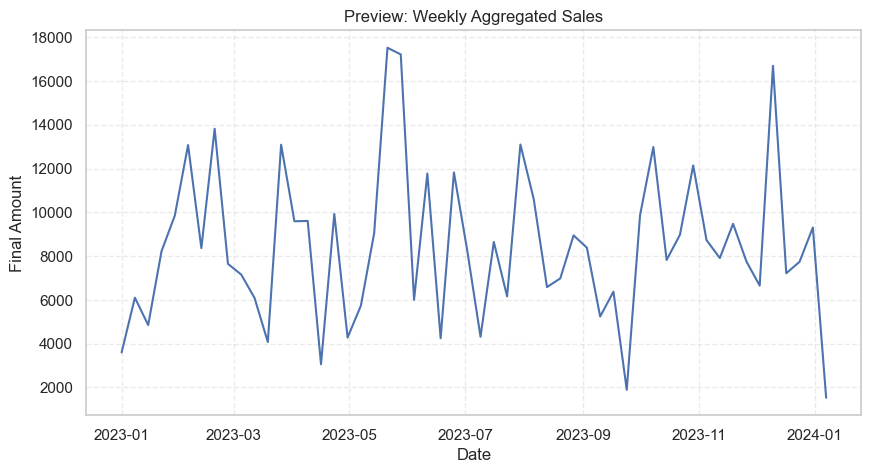


[3.3] Aggregating Customer-Level Features (RFM Basis)...
   -> Data customer berhasil diaggregasi
   -> Total customer unik: 1000

   -> Sample cust_agg:


,Customer_ID,Monetary,Frequency
0,CUST001,150,1
1,CUST002,1000,1
2,CUST003,30,1
3,CUST004,500,1
4,CUST005,100,1
5,CUST006,30,1
6,CUST007,50,1
7,CUST008,100,1
8,CUST009,600,1
9,CUST010,200,1



   -> Statistik ringkas cust_agg:


,Monetary,Frequency
count,1000.000000,1000.0
mean,456.000000,1.0
std,559.997632,0.0
min,25.000000,1.0
25%,60.000000,1.0
50%,135.000000,1.0
75%,900.000000,1.0
max,2000.000000,1.0


In [41]:
print("[3.2] Constructing Data (Resampling to Weekly)...")

print("   -> Sorting data berdasarkan kolom Date...")
df_sorted = df.set_index('Date').sort_index()

print("   -> Sample data setelah sorting:")
display(df_sorted.head(10))

print("\n   -> Melakukan resampling data ke level mingguan (weekly)...")

weekly_sales = df_sorted.resample('W')['final_amount'].sum().reset_index()

weekly_sales['Time_Index'] = range(len(weekly_sales))

print(f"   -> Data dikompres dari {len(df)} transaksi jadi {len(weekly_sales)} titik data mingguan")
print("   -> Grafik bakal lebih smooth dan tidak noise")

print("\n   -> Sample tabel weekly_sales:")
display(weekly_sales.head(10))

print("\n   -> Statistik ringkas weekly_sales:")
display(weekly_sales.describe())


plt.figure(figsize=(10,5))
plt.plot(weekly_sales['Date'], weekly_sales['final_amount'])
plt.title("Preview: Weekly Aggregated Sales")
plt.xlabel("Date")
plt.ylabel("Final Amount")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

print("\n[3.3] Aggregating Customer-Level Features (RFM Basis)...")

cust_agg = df.groupby('Customer ID').agg({
    'final_amount': 'sum',
    'fact_id': 'count'
}).reset_index()
cust_agg.columns = ['Customer_ID', 'Monetary', 'Frequency']

print("   -> Data customer berhasil diaggregasi")
print(f"   -> Total customer unik: {cust_agg.shape[0]}")

print("\n   -> Sample cust_agg:")
display(cust_agg.head(10))

print("\n   -> Statistik ringkas cust_agg:")
display(cust_agg.describe())



# ==========================================
# BLOK 4: MODELING
# ==========================================

[3.9] Evaluating Optimal Cluster (Elbow Method)...
   -> k=2, inertia=188.79
   -> k=3, inertia=80.07
   -> k=4, inertia=39.47
   -> k=5, inertia=19.58
   -> k=6, inertia=12.13
   -> k=7, inertia=4.66


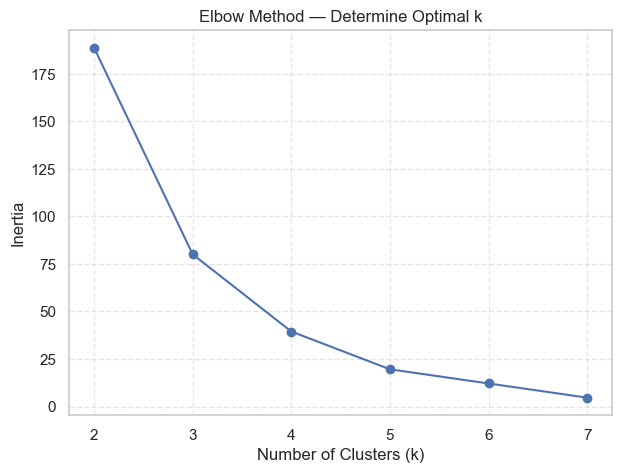


[3.10] Silhouette Score Check...
   -> k=2, silhouette=0.7867
   -> k=3, silhouette=0.7709
   -> k=4, silhouette=0.7598
   -> k=5, silhouette=0.7800
   -> k=6, silhouette=0.8177
   -> k=7, silhouette=0.7827
[4.1] Building K-Means Model...
[4.2] Building Regression Model (Weekly Trend)...
   -> Model Slope: 3.8654


In [42]:
print("[3.9] Evaluating Optimal Cluster (Elbow Method)...")

scaler = StandardScaler()
X_cluster = scaler.fit_transform(cust_agg[['Monetary', 'Frequency']])

inertia_vals = []
k_range = range(2, 8)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_cluster)
    inertia_vals.append(km.inertia_)
    print(f"   -> k={k}, inertia={km.inertia_:.2f}")

plt.figure(figsize=(7,5))
plt.plot(k_range, inertia_vals, marker='o')
plt.title("Elbow Method — Determine Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


print("\n[3.10] Silhouette Score Check...")
from sklearn.metrics import silhouette_score

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster)
    sil = silhouette_score(X_cluster, labels)
    print(f"   -> k={k}, silhouette={sil:.4f}")


print("[4.1] Building K-Means Model...")
scaler = StandardScaler()
X_cluster = scaler.fit_transform(cust_agg[['Monetary', 'Frequency']])
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cust_agg['Cluster'] = kmeans.fit_predict(X_cluster)

print("[4.2] Building Regression Model (Weekly Trend)...")
reg = LinearRegression()
X_reg = weekly_sales[['Time_Index']]
y_reg = weekly_sales['final_amount']
reg.fit(X_reg, y_reg)
print(f"   -> Model Slope: {reg.coef_[0]:.4f}")

last_idx = weekly_sales['Time_Index'].max()
future_X = np.array(range(last_idx + 1, last_idx + 5)).reshape(-1, 1)
future_vals = reg.predict(future_X)

last_date = weekly_sales['Date'].max()
future_dates = [last_date + pd.Timedelta(weeks=i) for i in range(1, 5)]

future_df = pd.DataFrame({'Date': future_dates, 'final_amount': future_vals, 'Type': 'Forecast'})
weekly_sales['Type'] = 'Actual'
combined = pd.concat([weekly_sales[['Date', 'final_amount', 'Type']], future_df])

# ==========================================
# BLOK 5: EVALUATION
# ==========================================

[5.3] Displaying Final Smoothed Charts...


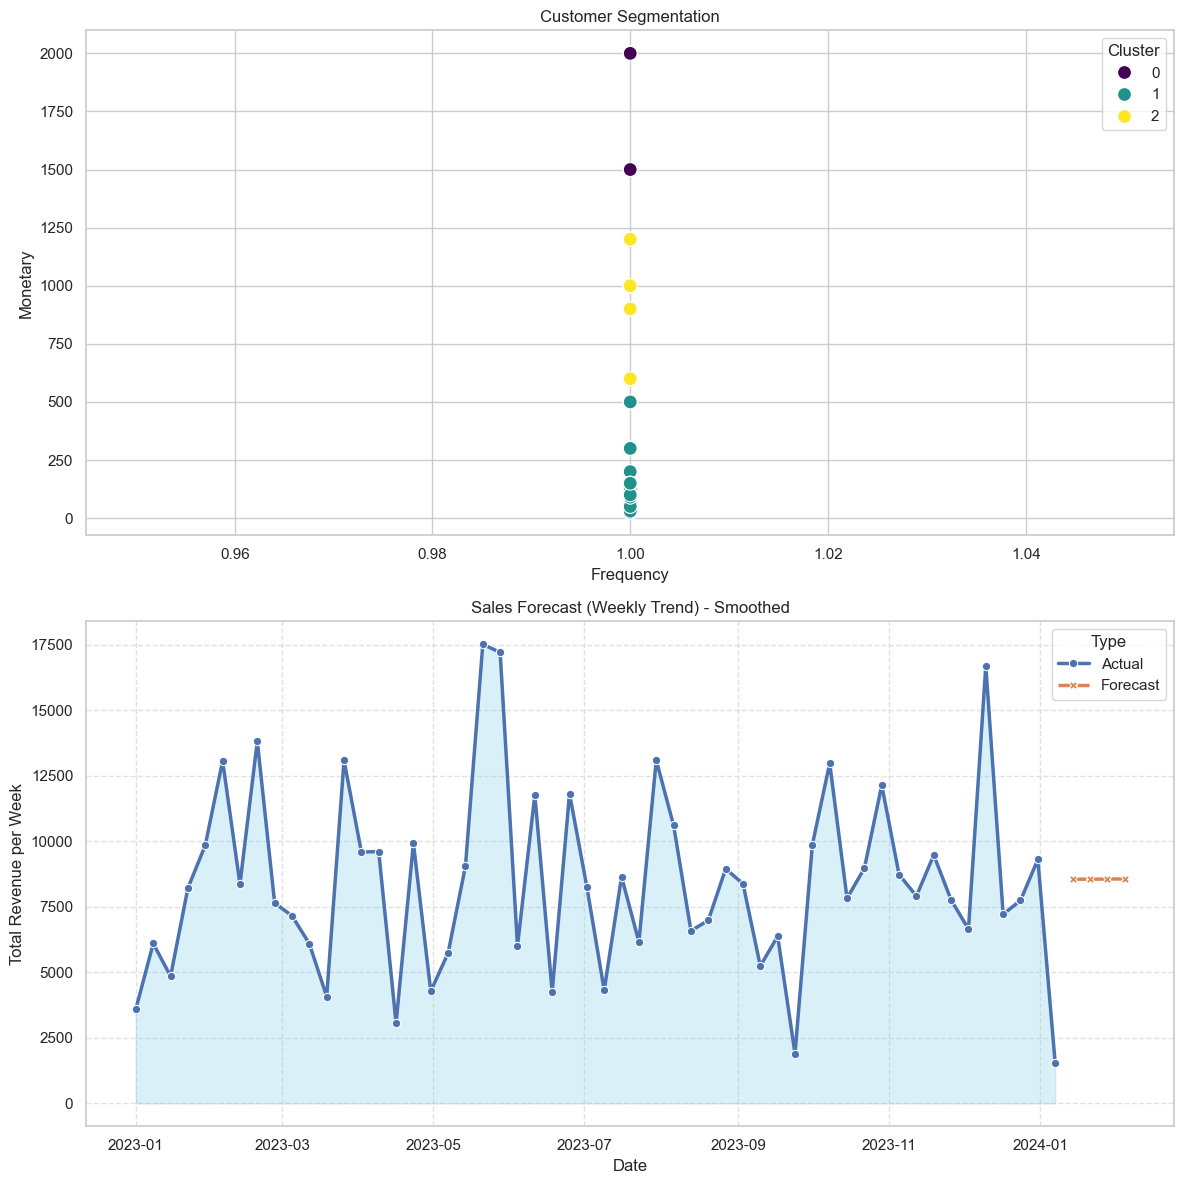

In [43]:
print("[5.3] Displaying Final Smoothed Charts...")
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.scatterplot(data=cust_agg, x='Frequency', y='Monetary', hue='Cluster', palette='viridis', s=100, ax=axes[0])
axes[0].set_title('Customer Segmentation')

sns.lineplot(data=combined, x='Date', y='final_amount', hue='Type', style='Type', markers=True, ax=axes[1], linewidth=2.5)

axes[1].fill_between(weekly_sales['Date'], weekly_sales['final_amount'], alpha=0.3, color='skyblue')

axes[1].set_title('Sales Forecast (Weekly Trend) - Smoothed')
axes[1].set_ylabel('Total Revenue per Week')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()